# PARTE 1 - ANALISE EXPLORATÓRIA DOS DADOS

In [1]:
# Bibliotecas para leitura, exploração, manipulação e visualização de dados
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline

# Biblioteca para o split/treino dos dados, métricas, modelagem
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder

from sklearn import svm
from sklearn import metrics
from sklearn.svm import SVC


#Bibliotecas para as Cross Validations
#Normalmente se usa uma ou outra, vou utilizar as duas para mostrar os pros e contras
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score


from sklearn.linear_model import LinearRegression
from sklearn.model_selection import learning_curve
from sklearn.model_selection import StratifiedShuffleSplit

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

import re,string,unicodedata
import nltk  
from nltk.corpus import stopwords

stop_words = nltk.corpus.stopwords.words('portuguese')

  
from nltk import tokenize    

#nltk.download('stopwords')

#Biblioteca para salvar os modelos para uso em app web(proximos passos)
import pickle


In [2]:
#Importando dataset de treino como df
df=pd.read_csv("train_data.csv", encoding='utf-8')


In [3]:
#Verificando o formato do dataframe
df.shape

(6000, 2)

In [5]:
#Verificando presença de Nulos
df.isna().sum()

SMS      0
LABEL    0
dtype: int64

Observa-se que não existem valores nulos no dataset. O mesmo possui 6000 registros e 2 features(colunas) apresentando, portanto  o formato de (6000,2)

In [6]:
#Explorando o dataframe
df.columns

Index(['SMS', 'LABEL'], dtype='object')

Percebe-se que o dataframe possui duas features: 'df[SMS]', onde reside a mensagem a ser classificada como "blocked" ou "ok" e 'df[LABEL]' onde se classifica a mensagem. Verifica-se que será preciso um minucioso trabalho de tratamento de texto na coluna 'SMS' uma vez que as mensagem estão poluidas com links, ips, pontuações etc..

In [7]:
df

,SMS,LABEL
0,BOLETO REFERENTE AS PARCELAS EM ATRASO DO CONS...,blocked
1,050003DA0202|lcloud-apple-lnc.com/?iphone=VtBq...,blocked
2,060804CB5F0303|ps: //bancodobrasil.seguranca.gq,blocked
3,Atualizacao ainda nao foi executado em sua con...,blocked
4,0608042BE40303|ps://bancodobrasil.seguranca.cf/,blocked
...,...,...
5995,Host : RB_Bicanga Ip: 170.244.231.14 nao esta ...,ok
5996,Host : RB§Bicanga Ip: 170.244.231.14 nao esta ...,ok
5997,Host : RB§Bicanga Ip: 170.244.231.14 nao esta ...,ok
5998,Host : RB_Bicanga Ip: 170.244.231.14 nao esta ...,ok


Analisando-se o dataframe apresentado acima já verificamos dois pontos importantes:  

1 - A necessidade de converpalavraos a feature LABEL para variáveis booleanas, sendo valor 0(zero) para mensagens 'ok' e valor 1 para mensagens 'blocked'

2 - Precisaremos tratar detalhadamento os textos da feature SMS, pradonizando-os da seguinte forma:


In [8]:
#Optei por subsituir a classificação de blocked / ok para booleanos, sendo 0 para 'ok' e 1 para 'blocked'

df['LABEL'] = df['LABEL'].apply(lambda x: 1 if x == 'blocked' else 0)

<AxesSubplot:xlabel='LABEL', ylabel='count'>

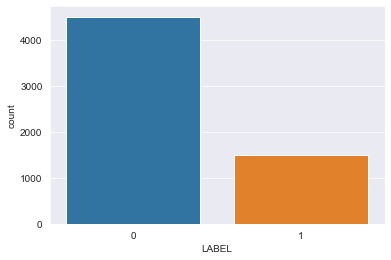

In [9]:
sns.set_style("darkgrid")
sns.countplot(df.LABEL)

Observa-se claramente pelo gráfico acima que a feature LABEL é desbalanceada, ou seja, existem mais valors 0('ok') do que valores 1 'blocked'. Esse desbalanço pode tornar o modelo "viciado" ou biased, ou seja, pode fazer com que ele classifique mais mesnsagens como 'ok' do que deveria.

Com este desbalanço o modelo poderia classificar mensagens 'blocked' como 'ok', ou seja, gerando um falso negativo, quando um mesagem que deveria ser bloqueada passa a ser liberada. Felizmente, um falso negativo não é tão grande quanto unm falso positivo, pois é "preferível" uma mensagens 'blocked' na caixa de de entrada, por exemplo, do que uma msg 'ok' na caixa de spams ( fazendo um paralelo com os filtros de spams dos emails)

Teremos que verificar a acurácia dos modelos para então decidirmos por um resampling (re-amostragem) ou não.

## 1.1 PREPARAÇÃO E LIMPEZA DOS DADOS - EDA

In [10]:
# Regex para substituir endereços de email pela string 'emailaddress'
df['SMS'] = df['SMS'].str.replace(r'^.+@[^\.].*\.[a-z]{2,}$', 'emailaddress')

# Regex para substituir endereços URL pela string'webaddress'
df['SMS'] = df['SMS'].str.replace(r'^http\://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$', 'webaddress')

# Regex para substituitr curreny pela string 'money-symbol'
df['SMS'] = df['SMS'].str.replace(r'£|\$', 'money-symbol')

# Substituindo telefones no padrão (XX)XXXXX-XXXX por'phone-number'
df['SMS'] = df['SMS'].str.replace(r'(\(?\d{0,2}\D{0,3}\d{5}\D{0,3}\d{4})', 'tel-numero')


# |Regex para substituir números quaisquer pela string 'number'
df['SMS'] = df['SMS'].str.replace(r'\d+(\.\d+)?', 'numero')

# Removendo pontuação
df['SMS'] = df['SMS'].str.replace(r'[^\w\d\s]', ' ')

# Regex
df['SMS'] = df['SMS'].str.replace(r'^\s+|\s*?$', ' ')

#Todas as palavras em minúsculas
df['SMS'] = df['SMS'].str.lower()

#Próximo passo aqui é colocar todos estes regex em uma função de modo que possa eliminar código nos usos posteriores.
#Não o fiz apenas para deixar mais didática a apresentação .

In [11]:
df

,SMS,LABEL
0,boleto referente as parcelas em atraso do cons...,1
1,tel numero lcloud apple lnc com iphone vtbqroy,1
2,numerocbnumerofnumero ps bancodobrasil segu...,1
3,atualizacao ainda nao foi executado em sua con...,1
4,tel numeronumero ps bancodobrasil seguranca ...,1
...,...,...
5995,host rb_bicanga ip numero numero nao esta r...,0
5996,host rb bicanga ip numero numero nao esta r...,0
5997,host rb bicanga ip numero numero nao esta r...,0
5998,host rb_bicanga ip numero numero nao esta r...,0


## 1.2 PLOTAGEM DA WORDCLOUD APÓS TRATAMENTO DAS MENSAGENS COM REGEX

O uso do recurso de visualização WordCloud é muito útil neste tipo de análise classificatória. Podemos aqui, visualmente, verificar quais palavras são mais comuns em cada categoria de mensagens: "ok" e "blocked".

Importante:  vou usar o wordcloud apenas para análise visual.  Esta ferramente não deve e não será usada para fins de treino do modelo. Para esta finalidade userei técnicas de NLP mais adequadas e que serão explicadas na sequência.

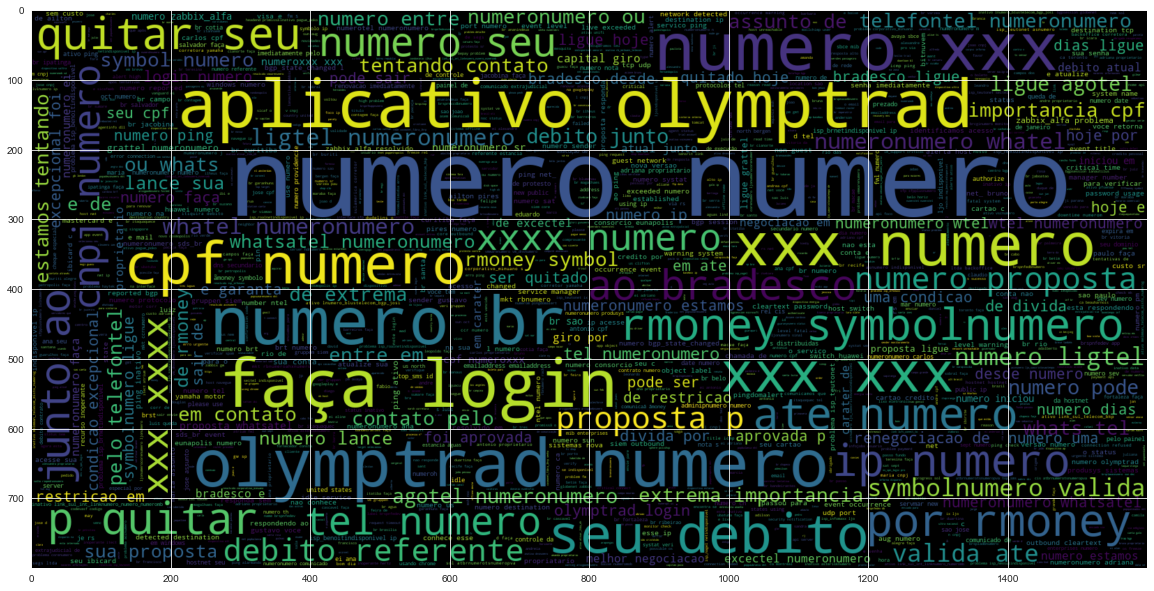

In [12]:
#WordCloud para mensagens OK!
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(df[df.LABEL == 0].SMS))
plt.imshow(wc , interpolation = 'bilinear')

Observa-se a alta frequência da palavra "numero" e "olymptrad" que vem de nosso regex. Tabmém vemos palavras como "quitar", "seu débito".

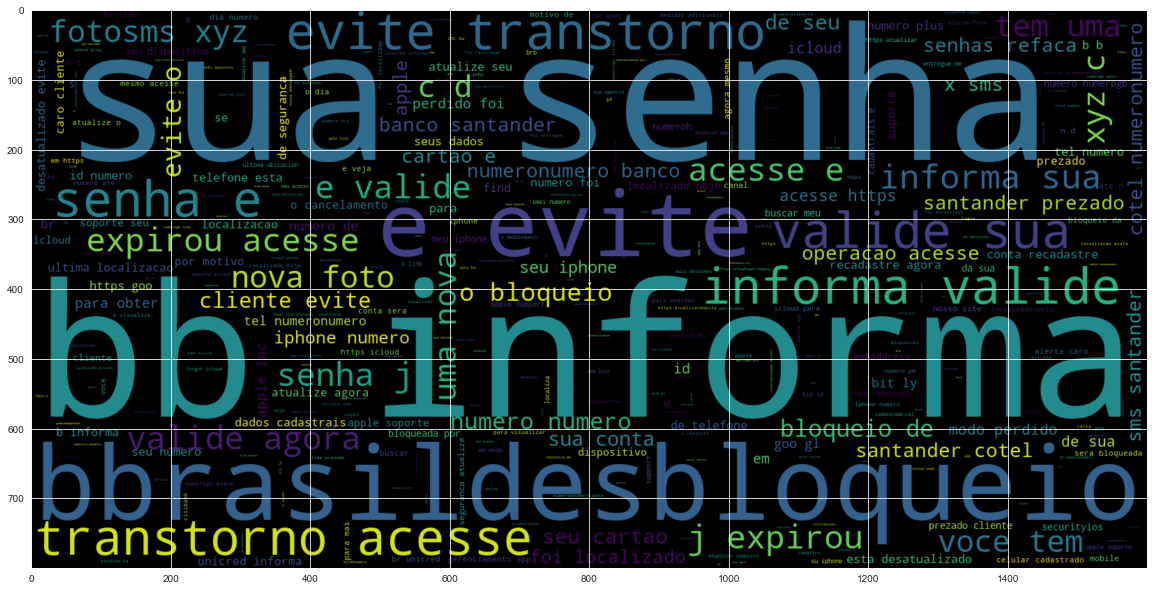

In [13]:
plt.figure(figsize = (20,20)) # Text that is Spam
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(df[df.LABEL == 1].SMS))
plt.imshow(wc , interpolation = 'bilinear')

Aqui vemos em destaque palavras como "sua senha", "evite transtornos", "bb informa", "desbloqueio","acesse o site" sendo estas palavras realmente muito utilizadas em sms's e email de spam.

Como análise geral das wordClouds, felizmente não existem palavras de alta frequência que sejam comuns aos dois labels, isso facilita muito a assertividade de nosso modelo.

## 1.3 PLOTAGEM DOS TAMANHOS MÉDIOS DAS PALAVRAS EM CADA TIPO DE MENSAGEM

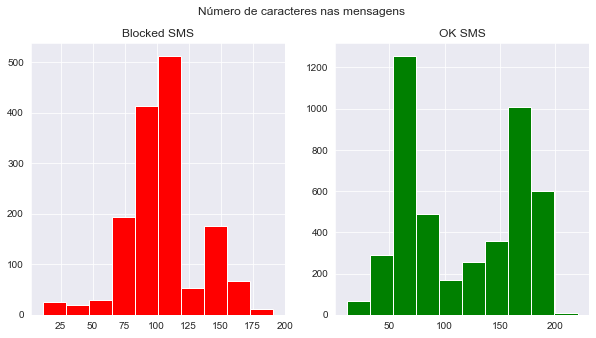

In [14]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
text_len=df[df['LABEL']==1]['SMS'].str.len()
ax1.hist(text_len,color='red')
ax1.set_title('Blocked SMS')
text_len=df[df['LABEL']==0]['SMS'].str.len()
ax2.hist(text_len,color='green')
ax2.set_title('OK SMS')
fig.suptitle('Número de caracteres nas mensagens')
plt.show()

As mensagens classificadas como blocked possuem um tamanho médio ao redor de 100 palavras, enquanto as mensagens classificadas como OK possuem tamanho médio em torno de 65 palavras. O modelo de classificação sofee grande impacto de acordo com o método de limpeza de texto utilizado. È necessário um esforço tremendo para definição da melhor estratégia de regex para tratamento das palavras, buscando palavras-chaves de alta frequência de uso em ambas as categorias: 'blocked' e 'ok'. Esta sistemática precisa ser constantemente verificada e aperfeiçoada pois dela depende gtrande parte da eficácia do medelo de classificação.

## 1.4 PREPARAÇÃO NLP (NATURAL LANGUAGE PROCESSING)

Todos os modelos de classificação que trabalham com textos, exigem que estes sejam convertidos em números, uma vez que os modelos mátemáticas envolvidos nos algoritmos de classifacação apenas "entendem" números.  

Existem várias técnicas para se converter texto em vetores numéricos, nesta análise vou me concentrar em utilizar a técnica de Tf-IDf:

### Tf-IDF (frequency-Inverse, Document Frequency

\[TfIDF = \frac{NC}{NPD} \ast \log \frac{TD}{NDcP}\] 

sendo,

NC   = número de vezes que a palavra aparece na mensagem,<br>
NPD  = númeroro de palavras na mensagem,<br>
TD   = número total de mensagens,<br>
NDcP = número de mensagens que possui aquele palavrao.

Resumindo esta técnica: quanto mais frequente uma palavra é em um sua mensagem, mais importante ela tende a ser. Entretanto, para uma análise de classificação, também precisamos verificar o quanto ela se repete em todas as outras mensagens também.

Por exemplo, estamos analisando 3 livros sobre carros: 1 sobre Ferraris, 1 sobre Fuscas e 1 sobre Fiats Uno Mille.  A palavra "carro" vai aparecer em todos os 3 livros, sendo que então não contribui muito para análise.  mas palavras como "alto custo", "esportivo" provavelmente não vão aparecer nos livros sobre fuscas ou fiats, mas seguramente é uma palavra importantissima para análise do livro sobre ferraris.

o TfIDf faz justamente isso: atribui importâncias, pesos, as palavras, analisando sua importância em todos os textos analisados.



#### Importante ressaltar uma terceira técnica que vêm crescendo em importância e promete ser o "estado da "arte" em NLP: Análise BERT. 
#### Não vou utilizar BERT neste estudo pois ainda estou estudando seu algoritmmos mas fica como "melhorias" a implantação desta técnica neste trabalho.

In [15]:
stop_words = set(stopwords.words('portuguese'))
df['SMS'] = df['SMS'].apply(lambda x: ' '.join(palavra for palavra in x.split() if palavra not in stop_words))


O código acima retira de todas as mensagens de texto na coluna 'SMS' as stop_words, substiuindo-as por espaços em branco.  O set de stop_words utilizado contém 204 palavra da língua portuguesa e foi disponibilizado no pacote NLTK.

## 1.4.2 STEMMING

A stemminzação é um técnica extremamente eficaz para redução de palavras à seu tronco de formação(stem). O tronco(stem) não precisa ser necessariamente igual a raiz morfológia da palavra, ele é adequado para relacionar palavras diferentes a um mesmo tronco.

A técnica vai ser utilizada aqui para facilitar a análise mas alguns cuidados precisam ser tomados, sendo o principal deles o over-stemming, conforme abaixo:

 "comportamento" e "comportado" , quando stemmizadas, reduzem-se à "comp",<br> 
 "comparar       e "comparou"   , quando stemmizadas, reduzem-se à "comp",<br> 
 
Obviamente que não são as mesmas palavras para serem as 4 derivadas a "comp".  Precisamos sempre evitar est tipo de má stemmização.
 
Como melhoria, devemos avaliar todas técnicas de stemmização disponíveis para encontrarmos a que melhor se encaixa em nosso projeto. 

Existem os seguintes algoritmos de stemmização:

Porters,<br>
Lovins,<br>
Dawson,<br>
Krovetz,<br>
N-Gram,<br>
Snowball,<br>
Lancaster<br>

Veja que existem vários, e todos com suas particularidades matémáticas.  Neste primeiro modelo vou tabalhar com Snowballs e no próximo com N-Gram.

E desenvolvimento para produção precisamos testar todos e verificar quais se comportam melhor.

Abaixo inseri um código para demonstrar o processo de stemmização/tokenização de strings em textos.
 
 
 
 

In [16]:
from nltk.stem.snowball import SnowballStemmer
def tokenize(text):
        """
        Tokenizes sequences of text and stems the tokens.
        :param text: String to tokenize
        :return: List with stemmed tokens
        """
        tokens = nltk.WhitespaceTokenizer().tokenize(text)
        tokens = list(set(re.sub("[^a-zA-Z\']", "", token) for token in tokens))
        tokens = [word for word in tokens if word not in stopwords.words('portuguese')]
        tokens = list(set(re.sub("[^a-zA-Z]", "", token) for token in tokens))
        stems =[]
        stemmer = SnowballStemmer("portuguese")
        for token in tokens:
            token = stemmer.stem(token)
            if token != "":
                stems.append(token)
        return stems 

In [17]:
tokenize('correndo para salvar uma corrida de salvamento correta no coração')

['corr', 'corr', 'cora', 'salvament', 'salv', 'corret']

Veja acima que as palavras:<br> 
{'correndo','corrida'}  reduzidas a {'corr},<br>
{'correta'} reduzida a {'corret'},<br>
{'coração'} reduzida a {'cora'}

esse é processo de stemmização e formação de tokens que será então transformados em vetores numéricos para posterior análise.<br>

As stop_words: 'para', 'uma', 'de' e 'no' foram retiradas corretamente da análise

Continuando com a análise aplicada ao nosso dataset original

In [18]:
ss = nltk.SnowballStemmer("portuguese")
df['SMS'] = df['SMS'].apply(lambda x: ' '.join(ss.stem(palavra) for palavra in x.split()))

In [19]:
sms_df = df['SMS']
from nltk.tokenize import word_tokenize

# creating a bag-of-words model
all_words = []
for sms in sms_df:
    words = word_tokenize(sms)
    for w in words:
        all_words.append(w)
     
all_words = nltk.FreqDist(all_words)

In [20]:
print('Numero de Palavras: {}'.format(len(all_words)))

Numero de Palavras: 4940


Aqui uma linha que extrai todas as palavras únicas em todas as rows em df['SMS']. O tamanho deveria ser o mesmo, por alguma razão percebemos uma diferença de 1 palavra que ainda não descobri o porquê.  Entretanto isso não vai impactar na acurácia de nosso modelo.

In [21]:
from collections import Counter
resultado = Counter()
df['SMS'].str.lower().str.split().apply(resultado.update)
print('Existem',len(resultado), 'palavras distintas em todo dataset')

Existem 4941 palavras distintas em todo dataset


In [22]:
len(resultado) == len(all_words) # diferença de uma palavra. Estranho mas não descobri porque, enfim, não vai impactr em nada.

False

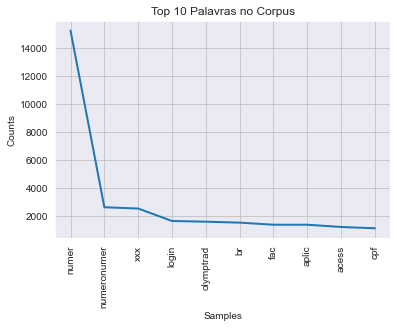

In [23]:
all_words.plot(10, title='Top 10 Palavras no Corpus');

Na plotagem da distribuição das 10 palavras distintas mais encontradas no corpus(conjunto dos textos dos 6000 sms) nós percebemos claramente uma altíssima frequência da palavra 'number' que foi nosso regex para substituir números. Como números podem ser enviados tanto em mensagens de SPAM ou mensagens OK, precisamos monitorar este regex pois ele pode prejudicar nossa classificação.

Para este modelo, não terei esta preocupação uma vez que a string ' number' não aparece na CloudWord das mensagens 'blocked' mas sim nas palabras 'ok'.

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_model = TfidfVectorizer()
tfidf_vec=tfidf_model.fit_transform(sms_df)

#Slvando o modelo em disco com a finalidade de no futuro portar para um app online com flask ou django.
#Queria ter feito o app online mas realmente vou deixar para o "futuro".

pickle.dump(tfidf_model, open("modelo_tfidf.pkl","wb"))
tfidf_data=pd.DataFrame(tfidf_vec.toarray())
tfidf_data.head()

,0,1,2,3,4,5,6,7,8,9,...,4907,4908,4909,4910,4911,4912,4913,4914,4915,4916
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
tfidf_data.shape

(6000, 4917)

Aqui aplicamos a biblioteca tfidf no nosso conjunto de 4971 palavras distintas (excluindo-se as stop_words). A ideia então é transformarmos as strings em uma matriz numérica onde cada posição ij na matriz corresponde a uma palavra e sua importância(peso) definida pelo algoritmo tfidf conforme já explicado.

In [26]:

df_train = tfidf_data.iloc[:4800]
df_test = tfidf_data.iloc[4800:]

target = df['LABEL']
df_train['LABEL'] = target

Y = df_train['LABEL']
X = df_train.drop('LABEL',axis=1)

# splitting training data into train and validation using sklearn
from sklearn import model_selection
X_train,X_test,y_train,y_test = model_selection.train_test_split(X,Y,test_size=.20, random_state=42)

O modelo escolhido para esta análise utiliza a técnica de Light Gradient Boosting Machine - LightGBM. basicamente, LightGBM utiliza técnica de 'decision trees' porém o crescimento das iterações se dá de maneira veritical, ou seja, 'leaf-wise'. Com isso, este algortimo apresenta alta velocidade de treinamento e foco em acurácia, tudo isso aliado ao baixo uso de memória e a possibilidade de pode ser utilizado em sistema com "GPU leaning".

É um algoritmo simples de ser aplicado mas muito complicado para ser ajustado.  Ele possui mais de 80 parâmetros possíveis de ajuste, sendo alguns deles extremamente importantes para se evitar overfitting principalmente.

Eu decido por rodar os modelos com alguns parâmetros que meu feeling diz que se ajustariam bem ao modelo, focando em:

max_depth: depalavraina o tamanho máximo da  'arvores de profundidade' Normalmente se busca o menos valor de depth para o maior F-Score para se evitar overfitting<br>

num_leaves: depalavraina o menor valor de registros que uma 'folha' pode ter. Padrão são 20 registros.<br>

Depois tenho uma decisao a fazer para a Cross Validation:  usar GridSearch ou Randomized Search

Optei por otimizar utilizando 'RandomizedSearchCV' porque já tenho uma idéia de quais parâmetros poderiam ser os mais adequados para a análise e para ganhar tempo computacional(não que seja um problema aqui, uma vez que o numero de features é muito baixo, mas poderia ser.)

Obs: Usarei GridSearchCV no próximo modelo apresentado.


In [27]:
import lightgbm as lgb
from sklearn.metrics import f1_score

def train_and_test(model, model_name):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    print(f'F1 score is: {f1_score(pred, y_test)}')
#Ao invés de setar depth diretamente, preferi mostrar iterações de 1:11 para mostrar seus valores   
for depth in [1,2,3,4,5,6,7,8,9,10]:
    lgbmodel = lgb.LGBMClassifier(max_depth=depth, n_estimators=200, num_leaves=40)
    print(f"Max Depth {depth}")
    print(" ")
    print(" ")
    train_and_test(lgbmodel, "Light GBM")

Max Depth 1
 
 
F1 score is: 0.9722222222222221
Max Depth 2
 
 
F1 score is: 0.9846153846153846
Max Depth 3
 
 
F1 score is: 0.9954198473282444
Max Depth 4
 
 
F1 score is: 0.9954198473282444
Max Depth 5
 
 
F1 score is: 0.9969418960244648
Max Depth 6
 
 
F1 score is: 0.9969418960244648
Max Depth 7
 
 
F1 score is: 0.9969418960244648
Max Depth 8
 
 
F1 score is: 0.9969418960244648
Max Depth 9
 
 
F1 score is: 0.9969418960244648
Max Depth 10
 
 
F1 score is: 0.9969418960244648


Em max_Depth=6 encontramos o maior valor de F1-Score: 0.9969

In [28]:
#Max_depth = 6


lgbmodel_bst = lgb.LGBMClassifier(max_depth=6, n_estimators=200, num_leaves=40,objective='binary')
param_grid = {
    'num_leaves': list(range(8, 92, 4)),
    'min_data_in_leaf': [10, 20, 40, 60, 100],
    'max_depth': [3, 4, 5, 6, 7, 12, 16, -1],
    'learning_rate': [0.1, 0.05, 0.01, 0.005],
    'bagging_freq': [3, 4, 5, 6, 7],
    'bagging_fraction': np.linspace(0.6, 0.95, 10),
    'reg_alpha': np.linspace(0.1, 0.95, 10),
    'reg_lambda': np.linspace(0.1, 0.95, 10),
    "min_split_gain": [0.0, 0.1, 0.01],
    "min_child_weight": [0.001, 0.01, 0.1, 0.001],
    "min_child_samples": [20, 30, 25],
    "subsample": [1.0, 0.5, 0.8]
    
    
}
model = RandomizedSearchCV(lgbmodel_bst, param_grid, random_state=1)
search = model.fit(X_train, y_train)
search.best_params_

[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=30 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] bagging_fraction is set=0.95, subsample=0.5 will be ignored. Current value: bagging_fraction=0.95
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=30 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] bagging_fraction is set=0.95, subsample=0.5 will be ignored. Current value: bagging_fraction=0.95
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=30 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] bagging_fraction is set=0.95, subsample=0.5 will be

[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_fraction is set=0.8722222222222222, subsample=0.8 will be ignored. Current value: bagging_fraction=0.8722222222222222
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_fraction is set=0.8722222222222222, subsample=0.8 will be ignored. Current value: bagging_fraction=0.8722222222222222
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=100
[LightGBM]

[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=30 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] bagging_fraction is set=0.7555555555555555, subsample=0.5 will be ignored. Current value: bagging_fraction=0.7555555555555555
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=30 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] bagging_fraction is set=0.7555555555555555, subsample=0.5 will be ignored. Current value: bagging_fraction=0.7555555555555555
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=30 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warn

{'subsample': 0.5,
 'reg_lambda': 0.47777777777777775,
 'reg_alpha': 0.1,
 'num_leaves': 64,
 'min_split_gain': 0.01,
 'min_data_in_leaf': 10,
 'min_child_weight': 0.001,
 'min_child_samples': 20,
 'max_depth': 12,
 'learning_rate': 0.1,
 'bagging_freq': 3,
 'bagging_fraction': 0.7166666666666667}

In [29]:
best_model = lgb.LGBMClassifier(subsample=0.5,
                            reg_lambda= 0.47777777777777775,
                            reg_alpha= 0.1,
                            num_leaves= 64,
                            min_split_gain= 0.01,
                            min_data_in_leaf= 10,
                            min_child_weight= 0.001,
                            min_child_samples= 20,
                            max_depth= 6,
                            learning_rate= 0.1,
                            bagging_freq= 3,
                            bagging_fraction= 0.71666667,
                            random_state=1)
best_model.fit(X_train,y_train)

LGBMClassifier(bagging_fraction=0.71666667, bagging_freq=3, max_depth=6,
               min_data_in_leaf=10, min_split_gain=0.01, num_leaves=64,
               random_state=1, reg_alpha=0.1, reg_lambda=0.47777777777777775,
               subsample=0.5)

In [30]:
prediction = best_model.predict(X_test)
lgbm_score = f1_score(prediction, y_test)
print(f'F1 score is: {f1_score(prediction, y_test)}')
(lgbm_score)

F1 score is: 0.9938837920489296


0.9938837920489296

F1 score excelente.  Vamos aceitar os parâmetros.

In [31]:
#Aqui estou salvando o modelo em disco para futura implementação de app web com flask por exemplo.
best_model.fit(tfidf_data, target)
pickle.dump(best_model, open("spam_model.pkl","wb"))

[LightGBM] [Warning] bagging_fraction is set=0.71666667, subsample=0.5 will be ignored. Current value: bagging_fraction=0.71666667
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


In [32]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [33]:
print(confusion_matrix(y_test,y_test))

[[632   0]
 [  0 328]]


Nosso modelo classificou corretamente 623 sms como 'ok' e 328 sms como 'blocked' em uma amostragem como 960 sms's.

In [34]:
print(classification_report(y_test,y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       632
           1       1.00      1.00      1.00       328

    accuracy                           1.00       960
   macro avg       1.00      1.00      1.00       960
weighted avg       1.00      1.00      1.00       960



In [35]:
validation_lgbm = pd.read_csv("validation_data.csv")

In [36]:
validation_lgbm.shape

(2000, 1)

In [37]:
validation_lgbm

,SMS
0,BB informa:Prezado cliente suas senhas de ACES...
1,BB informa:Prezado cliente suas senhas de ACES...
2,BB informa:Prezado cliente suas senhas de ACES...
3,Node Warning: SFRO01H000001.call.br Warning em...
4,BB informa:Prezado cliente suas senhas de ACES...
...,...
1995,Faça login no aplicativo OlympTrad?: 179.240.1...
1996,Faça login no aplicativo OlympTrad?: 179.240.1...
1997,bitnuvem.com: Identificamos acesso do IP 179.2...
1998,"enterinapplication: 179.240.169.116, BR, For..."


In [38]:
# Regex para substituir endereços de email pela string 'emailaddress'
validation_lgbm['SMS'] = validation_lgbm['SMS'].str.replace(r'^.+@[^\.].*\.[a-z]{2,}$', 'emailaddress')

# Regex para substituir endereços URL pela string'webaddress'
validation_lgbm['SMS'] = validation_lgbm['SMS'].str.replace(r'^http\://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$', 'webaddress')

# Regex para substituitr curreny pela string 'money-symbol'
validation_lgbm['SMS'] = validation_lgbm['SMS'].str.replace(r'£|\$', 'money-symbol')

# Substituindo telefones no padrão (XX)XXXXX-XXXX por'phone-number'
validation_lgbm['SMS'] = validation_lgbm['SMS'].str.replace(r'(\(?\d{0,2}\D{0,3}\d{5}\D{0,3}\d{4})', 'tel-numero')


# Regex para substituir números quaisquer pela string 'number'
validation_lgbm['SMS'] = validation_lgbm['SMS'].str.replace(r'\d+(\.\d+)?', 'numero')

# Removendo pontuação
validation_lgbm['SMS'] = validation_lgbm['SMS'].str.replace(r'[^\w\d\s]', ' ')

# Regex
validation_lgbm['SMS'] = validation_lgbm['SMS'].str.replace(r'^\s+|\s*?$', ' ')

#Todas as palavras em minúsculas
validation_lgbm['SMS'] = validation_lgbm['SMS'].str.lower()

In [39]:
model = pickle.load(open("spam_model.pkl", "rb"))
tfidf_model = pickle.load(open("modelo_tfidf.pkl", "rb"))

stop_words = set(stopwords.words('portuguese'))
validation_lgbm["SMS"] = validation_lgbm["SMS"].apply(lambda x: ' '.join(palavra for palavra in x.split() if palavra not in stop_words))
ss = nltk.SnowballStemmer("portuguese")
validation_lgbm["SMS"] = validation_lgbm["SMS"].apply(lambda x: ' '.join(ss.stem(palavra)for palavra in x.split()))

# tfidf_model = TfidfVectorizer()
tfidf_vec = tfidf_model.transform(validation_lgbm["SMS"])
tfidf_data = pd.DataFrame(tfidf_vec.toarray())
lgbm_prediction = model.predict(tfidf_data)

Para nossa predição utiizando o arquivo validation_data.csv, simplesmente procedemos com a limpeza e padronização dos textos na coluna 'SMS', carregamos o modelo treinado que foi salvo com ajuda da lib "pickle". 

In [40]:
len(lgbm_prediction)

2000

In [41]:
validation_lgbm['LABEL']=pd.Series(lgbm_prediction)

In [42]:
validation_lgbm.shape

(2000, 2)

In [43]:
validation_lgbm

,SMS,LABEL
0,bb inform prez client senh acessnumer sera blo...,1
1,bb inform prez client senh acessnumer sera blo...,1
2,bb inform prez client senh acessnumer sera blo...,1
3,nod warning sfronumerohnumer call br warning n...,0
4,bb inform prez client senh acessnumer sera blo...,1
...,...,...
1995,fac login aplic olymptrad numer numer br fortal,0
1996,fac login aplic olymptrad numer numer br fortal,0
1997,bitnuv identific acess ip numer numer cont num...,0
1998,enter in application numer numer br fortal,0


In [44]:
#Convertendo de volta as booleanas para variáveis categóricas
validation_lgbm['LABEL'] = validation_lgbm['LABEL'].apply(lambda x: 'blocked' if x == 1 else 'ok')

In [45]:
validation_lgbm

,SMS,LABEL
0,bb inform prez client senh acessnumer sera blo...,blocked
1,bb inform prez client senh acessnumer sera blo...,blocked
2,bb inform prez client senh acessnumer sera blo...,blocked
3,nod warning sfronumerohnumer call br warning n...,ok
4,bb inform prez client senh acessnumer sera blo...,blocked
...,...,...
1995,fac login aplic olymptrad numer numer br fortal,ok
1996,fac login aplic olymptrad numer numer br fortal,ok
1997,bitnuv identific acess ip numer numer cont num...,ok
1998,enter in application numer numer br fortal,ok


In [46]:
#Salvando a classificação em disco em aquivo .csv
validation_lgbm.to_csv('LGBM_validation.csv')

# PARTE 2  - Abordagem SVM LINEAR

Como já conhecemos o dataset 'train_data.csv" vou passar rapidamente na preparação apenas mudando o método de limpeza das palavras, onde preferi fazer como função para facilitar o código e explorar outras alternativas.

In [47]:
df=pd.read_csv("train_data.csv", encoding='utf-8')

In [48]:
df.shape

(6000, 2)

In [49]:
y=df['LABEL']
y.value_counts()

ok         4500
blocked    1500
Name: LABEL, dtype: int64

Relacação 'ok' / 'blocked' é de 3:1 o que pode sugeri ao modelo que o dataset é desbalancendo na feature target. Isso é uma preocupação que devemos ter aqui, uma vez que SVM é muito sensível a dataset desbalanceados, devendo ser corrigido caso necessário.  Vamos verificar:

 Abaixo crio, para efeitos ilustrativos datasets de alto desbalanceamento [1:50, 1:5] até dataset balanceados [1:2,5 e 1:1,25]

O dataset enviado é o de relação 1:3, o terceiro gráfico abaixo.  Por hora vamos tratá-lo como balanceado e verificar.


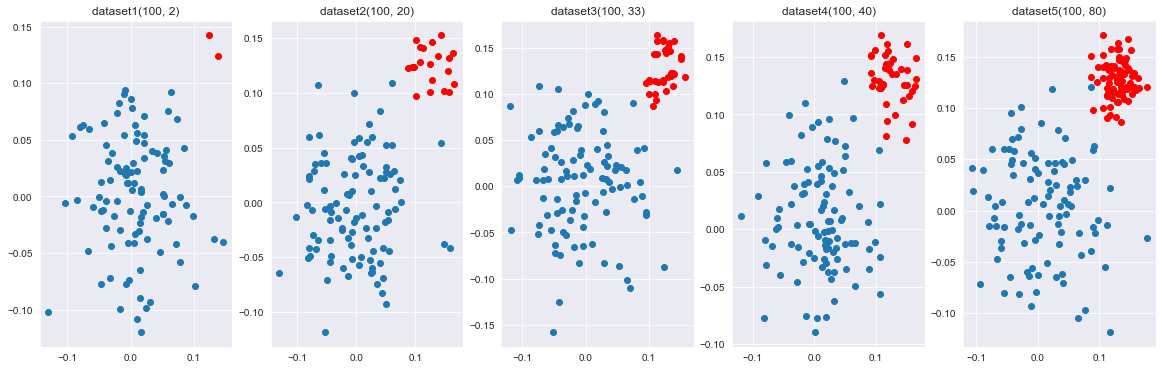

In [50]:
#import numpy as np
#import matplotlib.pyplot as plt
ratios = [(100, 2), (100, 20),(100,33),(100, 40), (100, 80)]
plt.figure(figsize = (20,6))
for j,i in enumerate(ratios):
 plt.subplot(1, 5, j+1) 
 X_p=np.random.normal(0,0.05,size=(i[0],2))
 X_n=np.random.normal(0.13,0.02,size=(i[1],2))
 y_p=np.array([1]*i[0]).reshape(-1,1)
 y_n=np.array([0]*i[1]).reshape(-1,1)
 X=np.vstack((X_p,X_n))
 y=np.vstack((y_p,y_n))
 plt.title("dataset" + str(j+1) +str(i))
 plt.scatter(X_p[:,0],X_p[:,1])
 plt.scatter(X_n[:,0],X_n[:,1],color='red')
plt.show()

Observa-se claramento o aumento do balanceamento à medida que caminhamos da esquerda para direita

In [51]:
#Subsituir a classificação de blocked / ok para booleanos, sendo 0 para 'ok' e 1 para 'blocked'

df['LABEL'] = df['LABEL'].apply(lambda x: 1 if x == 'blocked' else 0)

In [52]:
df.shape

(6000, 2)

In [53]:
y_enc=df['LABEL']

In [54]:
raw_text = df['SMS']

In [55]:
raw_text

0       BOLETO REFERENTE AS PARCELAS EM ATRASO DO CONS...
1       050003DA0202|lcloud-apple-lnc.com/?iphone=VtBq...
2         060804CB5F0303|ps: //bancodobrasil.seguranca.gq
3       Atualizacao ainda nao foi executado em sua con...
4         0608042BE40303|ps://bancodobrasil.seguranca.cf/
                              ...                        
5995    Host : RB_Bicanga Ip: 170.244.231.14 nao esta ...
5996    Host : RB§Bicanga Ip: 170.244.231.14 nao esta ...
5997    Host : RB§Bicanga Ip: 170.244.231.14 nao esta ...
5998    Host : RB_Bicanga Ip: 170.244.231.14 nao esta ...
5999    050003730201|Faça login no aplicativo OlympTra...
Name: SMS, Length: 6000, dtype: object

In [56]:
texto_processado = raw_text.str.replace(r'\b[\w\-.]+?@\w+?\.\w{2,4}\b','emailaddr')
texto_processado = texto_processado.str.replace(r'(http[s]?\S+)|(\w+\.[A-Za-z]{2,4}\S*)','httpaddr')
texto_processado = texto_processado.str.replace(r'£|\$', 'moneysymb')    
texto_processado = texto_processado.str.replace(r'\b(\+\d{1,2}\s)?\d?[\-(.]?\d{3}\)?[\s.-]?\d{3}[\s.-]?\d{4}\b','tel-numero')    
texto_processado = texto_processado.str.replace(r'\d+(\.\d+)?', 'numero')
texto_processado = texto_processado.str.replace(r'[^\w\d\s]', ' ')
texto_processado = texto_processado.str.replace(r'\s+', ' ')
texto_processado = texto_processado.str.replace(r'^\s+|\s+?$', '')
texto_processado = texto_processado.str.lower()

In [57]:
#Apenas retirando as stop_words do textos como já explicado na primeira análise
texto_processado = texto_processado.apply(lambda x: ' '.join(
    palavra for palavra in x.split() if palavra not in set(stop_words))
)

Coforme comentado na introdução teórica de stemmização, existem várias técnicas para fazê-lo.  No lightGBM utilizei Snowball.  Aqui vamos utilizar utilizar Porter com N-grams e verificarmos adequação.

In [58]:
porter = nltk.PorterStemmer()
texto_processado = texto_processado.apply(lambda x: ' '.join(
    porter.stem(palavra) for palavra in x.split())
)

In [59]:
'''
    Aqui busquei uma outra forma de limpeza de texto: 
    
    1.  Em textoprocessado usei str.replace - replace() não trabalha com regex, apenas substitui literal strings
        por isso se torna muito lento em grandes datasets.
    
    2.  Em preprocess_text vou usar re.sub que aceita regex e em grandes datasets regex é muito mais eficiente.
    
'''
def preprocess_text(messy_string):
     assert(type(messy_string) == str)
     cleaned = re.sub(r'\b[\w\-.]+?@\w+?\.\w{2,4}\b', 'emailaddr', messy_string)
     cleaned = re.sub(r'(http[s]?\S+)|(\w+\.[A-Za-z]{2,4}\S*)', 'httpaddr',
                      cleaned)
     cleaned = re.sub(r'£|\$', 'moneysymb', cleaned)
     cleaned = re.sub(r'\b(\+\d{1,2}\s)?\d?[\-(.]?\d{3}\)?[\s.-]?\d{3}[\s.-]?\d{4}\b','tel-numero', cleaned)
     cleaned = re.sub(r'\d+(\.\d+)?', 'numero', cleaned)
     cleaned = re.sub(r'[^\w\d\s]', ' ', cleaned)
     cleaned = re.sub(r'\s+', ' ', cleaned)
     cleaned = re.sub(r'^\s+|\s+?$', '', cleaned.lower())
     return ' '.join(
         porter.stem(palavra) 
         for palavra in cleaned.split()
         if palavra not in set(stop_words)
    )

In [60]:
#Check de para verificar se os dois métodos de limpeza resultaram nos mesmos textos.  Deveria retornar 'True'
(texto_processado == raw_text.apply(preprocess_text)).all()

True

In [61]:
exemplo = 'Acesse agora http://www.voutehacker.com e mude sua senha ou ligue para 0800 123-234455 ou envie email para axur@gmail.com.br'

In [62]:
preprocess_text(exemplo)

'acess agora httpaddr mude senha ligu numero numero numero envi email httpaddr'

In [63]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2))
X_ngrams = vectorizer.fit_transform(texto_processado)

In [64]:
X_ngrams.shape

(6000, 10987)

In [65]:
X_train, X_test, y_train, y_test = train_test_split(
    X_ngrams,
    y_enc,
    test_size=0.2,
    random_state=42,
    stratify=y_enc
)

clf = svm.LinearSVC(loss='hinge')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

metrics.f1_score(y_test, y_pred)


0.9915966386554621

Vimos ao rodar o script.py que o Kernel=sigmoid foi o que apresentou o melhor F1_score. Aqui, novamente, após todo tratamento nos textos, o modelo sigmoid continuou apresentando a melhor acurácia: 0.9932, contra 0.9915 do modelo Linear. Como a diferença é mínima, para fins de ganho de velocidade segui com Kernel Linear pois é muito mais rápido para treinar no GridSearch que quero explorar neste modelo. Uma 10-fold CV com sigmoid usando jobs:-1(1 trabalho por core) demorou 30 minutos para treinar no meu note, entao segui com o Linear e o resultado, na minha análise foi igualmente aceitável.

Obs: por padrão, efetua-se o CV do SVM com k-fold = 5 e testa-se, mas no sigmoidal percebi que k-folda=10 estava se comportando melhor, mas com incrivel perda de velocidade no meu notebook.

In [66]:
pd.DataFrame(
    metrics.confusion_matrix(y_test, y_pred),
    index=[['actual', 'actual'], ['blocked', 'ok']],
    columns=[['predicted', 'predicted'], ['blocked', 'ok']]
)

predicted     
                 blocked   ok
actual blocked       900    0
       ok              5  295

O modelo apresentou um F-Score de 0.9915, o que é ótimo. Entretando, ainda asism classificou 5 mensagens como SPAMS quando eram NAO-SPAMS, 1,67% de falso positivo. 

Um falso positivo é o pior cenário, uma vez que raramente verificamos a caixa de spam(no caso de emails) equanto que um falso negativo é muito fácil de resolver: apenas deletamos.

Precisamos melhor aqui!

In [67]:
len(raw_text)
sample_space = np.linspace(500, len(raw_text) * 0.8, 10, dtype='int')
print(sample_space)

[ 500  977 1455 1933 2411 2888 3366 3844 4322 4800]


Abaixo selecionamos os parâmetros mais importantes para o modelo SVM:

Kernel: vamos utilizar Linear, apesar de ter performado ligeiramente abaixo do modelo sigmoid no teste de seleção dos modelos. O parâmetro 'C' é um dos parâmetros mais importantes após a escolha do Kernel. É ele quem informa ao algoritmo a influência que a miss-classificação está fazendo ao nosso modelo.

Tentando ser mais claro: Em SVM nós queremos duas coisas:<br>
(1) - Um hiperplano com a margem mínima maior possível;<br>
(2) - Um hiperplano que consiga separar a feature target corretamento o maior número de vezes possível.<br>

Na vida real raramente conseguimos os pontos (1) e (2) ao mesmo tempo.  É justamente ai que entra o parâmetro C: ele diz o quanto você quer a condição (2) em detrimento à condição (1).

O que vou fazer:  Vou usar um alto valor de (C) para garantir *com este dataset* a classificação mais correta possível, pois o *dataset de validação disponibilizado*  é único.  

No mundo real,onde os dados mudam a todo instante esta minha escolha seria trágica para o modelo: ele classificaria bem semanas, senão dias após o deploy, e logo nao estaria performando corretamente.

train_sizes: decidi por dividir o tamanho do nosso dataset de teste que é composto por 6000 mensagens de texto em 4800(split 80:20) e estes 4800 gerando um train-size de 500 a 4800 divido em 10 valores: [500, 977, 1455, 1933, 2411, 2888, 3366, 3844, 4322, 4800]

In [68]:
sample_space = np.linspace(500, len(raw_text) * 0.8, 10, dtype='int')

train_sizes, train_scores, valid_scores = learning_curve(
    estimator=svm.LinearSVC(loss='hinge', C=1e10),
    X=X_ngrams,
    y=y_enc,
    train_sizes=sample_space,
    cv=StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=40),
    scoring='f1',
    n_jobs=-1
)

In [69]:
def make_tidy(sample_space, train_scores, valid_scores):
    messy_format = pd.DataFrame(
        np.stack((sample_space, train_scores.mean(axis=1),
                  valid_scores.mean(axis=1)), axis=1),
        columns=['# of training examples', 'Training set', 'Validation set']
    )
    
    return pd.melt(
        messy_format,
        id_vars='# of training examples',
        value_vars=['Training set', 'Validation set'],
        var_name='Scores',
        value_name='F1 score'
    )

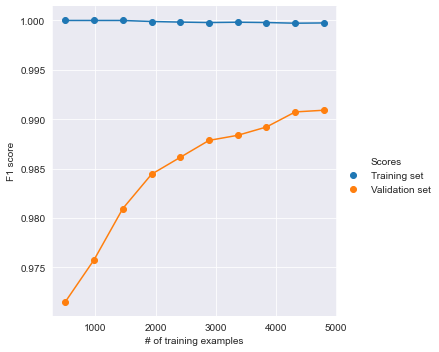

In [70]:
g = sns.FacetGrid(
    make_tidy(sample_space, train_scores, valid_scores), hue='Scores', size=5
)

g.map(plt.scatter, '# of training examples', 'F1 score')
g.map(plt.plot, '# of training examples', 'F1 score').add_legend();

visualização da Learnin Curve - Extremamente importante a visualização deste conceito: Percebe-se que a performance do dataset de treino é praticamente perfeita, o que pode explica-se pelo fato de estarmos classificando a feature-target no mesmo dataset que usamos para treinar o modelo !

A uma primeira análise a curva de validação apresenta alta variancia e parece não caminhar para convergência.
Entretanto, olhando atentamente a escala do eixo y (F1 Score) faz-me decidir que não há overfitting.

Com tudo, já que o F-Score continua aumentando com o aumanto do validation set, podemos adquirir mais dataset ou limitar a stemmização a utilização de apenas "unigrams" ao invés de usarmos "bigrams" e "unigrams".  Essa seria a melhoria para nosso modelo neste ponto.  

Decido seguir com a stemmização desta forma e trabalhar no tunning usando GridSearchCV.

Aqui vou utilizar a técnica de GridSearchCV do Scikit-Learn, visando treinar com uma série condições candidatos que utilizam diversas combinações de hiperparametros visando a melhor condição para nosso modelo.  Isso é feito utilizando-se Cross Validation, onde a ferramenta busca uma série de otimizações e como rsultando apresenta a melhor condição entre as k-fold condições setadas.  Neste caso usarei um k-folda = 10, ou seja, o GriDSearchCV varerá 10 condições de setagem dos hiperparâmetros e retornará a melhor.

Importante salientar que esta "técnica" pode gerar resultados viciados se feita de forma incorreta. A k-fold cross validation usando o mesmo dataset de treino para todas as k-fold runs pode ficar "viciado" devido potencial "leak" de informações entra os k-experimentos.

o mais correto seria conduzir uma nested-cross validation, ou cross validation aninhada, onde utilizamos a k-fold validation para treinar k modelos(loop externo). Depois, utilizando o data-set de cada um destes k experimentos, conduzimos uma GridSearchCV para tunning dos hiperparâmetros e selecionamos a melhor condições(melhor modelo do loop interno).

Conduzindo uma Nested k-Fold cross-validation usando agora GridSearchCV.  Veja como agora o tempo de validação é muito maior quando comparado ao RamdomizedSearchCV que usamos na análise de LightGBM.

Obs: o tempo não vai ser muito diferente no kernel Linear, mas no Kerner Sigmoid levou 33 minutos no meu note. Claro 10-fold pode ser overkill, ainda mais com njobs=-1.  Mesmo assim, segui com estes parametros no Linear pois treinou bem.

In [71]:
param_grid = [{'C': np.logspace(-4, 4, 20)}]

grid_search = GridSearchCV(
    estimator=svm.LinearSVC(loss='hinge'),
    param_grid=param_grid,
    cv=StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42),
    scoring='f1',
    n_jobs=-1
)

scores = cross_val_score(
    estimator=grid_search,
    X=X_ngrams,
    y=y_enc,
    cv=StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=0),
    scoring='f1',
    n_jobs=-1
)

scores

array([0.98989899, 0.98648649, 0.99328859, 0.98477157, 0.98653199,
       0.99162479, 0.99159664, 0.98989899, 0.99497487, 0.98310811])

Os k-folds experimentos mostram que nosso sistema de classificação está consistente.  Vamos verificar o F-Score.

In [72]:
svc_score = scores.mean()
scores.mean()

0.9892181028779736

F-Score aceitável. Seguimos com estes parâmetros.

In [73]:
grid_search.fit(X_ngrams, y_enc)
final_clf = svm.LinearSVC(loss='hinge', C=grid_search.best_params_['C'])
final_clf.fit(X_ngrams, y_enc);

Importante comentar aqui a métrica: loss='hinge' - Em classificações binárias a label y_true está encodada entre +1 e -1. Então, quando uma predição"erra" a métrica  "margin=y_true * pred_decision" é sempre negativa uma vez que
que os sinais +- = - implicando que 1-margin vai ser sempre maior que 1, ou seja, o modelo vai se auto-penalizando cada vez que erra e o hinge loss está lá para corrigir as próximas predições após o erro.

Eu estudei muito SVM e gosto demais deste modelo, creio que uma explicação muito detalhada de hiperplanos ficaria deveras massante neste caso. Mas estou disponível caso precisem !

In [74]:

pd.Series(
    final_clf.coef_.T.ravel(),
    index=vectorizer.get_feature_names()
).sort_values(ascending=False)[:20]


httpaddr              1.963169
appl                  1.956931
acess httpaddr        1.935074
acess                 1.874253
iphon                 1.395302
appi                  1.029128
informa               1.007044
app httpaddr          0.987160
reiniciar senha       0.950501
httpaddr reiniciar    0.950501
localizado            0.941752
mobil                 0.939266
client                0.935238
obter                 0.917880
httpaddr obter        0.910950
numero acess          0.898023
ha                    0.896324
voce                  0.896221
iphon numero          0.893173
servidor httpaddr     0.878945
dtype: float64

acima as 20 top strings que nosso modelo de stemm/token/classificação encontrou como extremamente impactantes

In [75]:
def spam_filter(message):
    if final_clf.predict(vectorizer.transform([preprocess_text(message)])):
        return 'blocked'
    else:
        return 'ok'

Coloquei nosso modelo em uma função para "brincarmos um pouco".  Vamos tentar enganá-lo:

In [76]:
spam_filter("banco")

'ok'

mensagem com a palavra banco foi "aprovada" pelo modelo.

In [77]:
spam_filter("banco do brasil")

'blocked'

Quando a palavra "banco" é associada ao banco "do brasil" nosso sistema classifica como blocked.

In [78]:
spam_filter("banco de sangue")

'ok'

"banco"  de sangue foi adequadamente classificada como 'ok'

In [79]:
spam_filter("banco itau")

'blocked'

In [80]:
spam_filter("banco bradesco")

'ok'

Aqui vem um ponto de melhoria:  nosso dataset de treino tem os bancos itau e do brasil mas naoo têm o banco bradesco. Precisaríamos trabalhar na inteligência do preparo NLP do modelo, focando em fraudes bancárias.

In [81]:
spam_filter("banco bradesco e banco do brasil")

'blocked'

In [82]:
spam_filter("negocie sua divida")

'ok'

Um sms de proposta para negociar sua dívida foi corretamente aceito.

In [83]:
spam_filter("negocie sua divida clicando em http://www.cliqueaqui.com.br")

'blocked'

Um sms pedindo para clicar em um link para "negociar sua dívida", ai já é perigoso!

In [84]:
spam_filter("troque sua senha")

'ok'

Perfeitamente normal um sms te lembrando para trocar sua senha, por segurança.

In [85]:
spam_filter("evite o bloqueio de sua conta troque sua senha")

'blocked'

Agora trocar a senha para evitar o bloqueio da sua conta, ai já é golpe !

In [86]:
spam_filter("JOSE,CNPJ 00986.xxx/xxxx-00,proposta p/ quitar seu debito referente a RENEGOCIACAO DE DIVIDA por R$354.23 valida ate 08/03. Ligue 08006002934 /whats 11997193858")

'ok'

Esse é um trick one !! Tenho dúvidas se era para ser blocked.  Entendo sim, mas o modelo entendeu que não. :-(

obs: o modelo sigmoidal classificou como 'blocked' a linha acima.

Aqui vamos carregar o dataset de validação, perfazer o mesmo tratamento de regex e texto e rodar nosso modelo. Não Vou entrar em detalhes aqui, uma vez que os passos que considerei mais relevantes já foram explicados no treino.

In [87]:
validation_svm = pd.read_csv("validation_data.csv")

In [88]:
raw_text = validation_svm['SMS']

In [89]:
texto_processado = raw_text.str.replace(r'\b[\w\-.]+?@\w+?\.\w{2,4}\b','emailaddr')
texto_processado = texto_processado.str.replace(r'(http[s]?\S+)|(\w+\.[A-Za-z]{2,4}\S*)','httpaddr')
texto_processado = texto_processado.str.replace(r'£|\$', 'moneysymb')    
texto_processado = texto_processado.str.replace(r'\b(\+\d{1,2}\s)?\d?[\-(.]?\d{3}\)?[\s.-]?\d{3}[\s.-]?\d{4}\b','tel-numero')    
texto_processado = texto_processado.str.replace(r'\d+(\.\d+)?', 'numero')
texto_processado = texto_processado.str.replace(r'[^\w\d\s]', ' ')
texto_processado = texto_processado.str.replace(r'\s+', ' ')
texto_processado = texto_processado.str.replace(r'^\s+|\s+?$', '')
texto_processado = texto_processado.str.lower()

stop_words = nltk.corpus.stopwords.words('portuguese')
texto_processado = texto_processado.apply(lambda x: ' '.join(
    palavra for palavra in x.split() if palavra not in set(stop_words))
)
porter = nltk.PorterStemmer()
texto_processado = texto_processado.apply(lambda x: ' '.join(
    porter.stem(palavra) for palavra in x.split())
)
def preprocess_text(messy_string):
    assert(type(messy_string) == str)
    cleaned = re.sub(r'\b[\w\-.]+?@\w+?\.\w{2,4}\b', 'emailaddr', messy_string)
    cleaned = re.sub(r'(http[s]?\S+)|(\w+\.[A-Za-z]{2,4}\S*)', 'httpaddr',
                     cleaned)
    cleaned = re.sub(r'£|\$', 'moneysymb', cleaned)
    cleaned = re.sub(
        r'\b(\+\d{1,2}\s)?\d?[\-(.]?\d{3}\)?[\s.-]?\d{3}[\s.-]?\d{4}\b',
        'tel-numero', cleaned)
    cleaned = re.sub(r'\d+(\.\d+)?', 'numero', cleaned)
    cleaned = re.sub(r'[^\w\d\s]', ' ', cleaned)
    cleaned = re.sub(r'\s+', ' ', cleaned)
    cleaned = re.sub(r'^\s+|\s+?$', '', cleaned.lower())
    return ' '.join(
        porter.stem(palavra) 
        for palavra in cleaned.split()
        if palavra not in set(stop_words)
    )

In [90]:
svm_pred = raw_text.apply(spam_filter)   

In [91]:
validation_svm['LABEL']=pd.Series(svm_pred)

In [92]:
validation_svm['LABEL'] = validation_svm['LABEL'].apply(lambda x: 'blocked' if x == 1 else 'ok')

In [93]:
#Salvando a calssificação em disco
validation_svm.to_csv('SVM_validation.csv')

## ABORDAGEM NAIVE BAYES

Vou passar sem maiores detalhes no carregamento, limpeza e preparação do data set pois já foi explicado nos dois modelos acima.

In [94]:
df=pd.read_csv("train_data.csv", encoding='utf-8')

In [95]:
a = df['SMS']
message = [line.rstrip() for line in a]
print(len(message))

6000


Apenas outras formas de trabalhamos os textos, nada muito novo aqui.

In [96]:
import string
mess = 'exemplo !! ??  Axur <> !|#...'
nopunc=[char for char in mess if char not in string.punctuation]
nopunc=''.join(nopunc)
print(nopunc)


exemplo    Axur  


In [97]:
#Importando novamente apenas para efeitos didáticos
from nltk.corpus import stopwords
stopwords.words('portuguese')

['de',
 'a',
 'o',
 'que',
 'e',
 'é',
 'do',
 'da',
 'em',
 'um',
 'para',
 'com',
 'não',
 'uma',
 'os',
 'no',
 'se',
 'na',
 'por',
 'mais',
 'as',
 'dos',
 'como',
 'mas',
 'ao',
 'ele',
 'das',
 'à',
 'seu',
 'sua',
 'ou',
 'quando',
 'muito',
 'nos',
 'já',
 'eu',
 'também',
 'só',
 'pelo',
 'pela',
 'até',
 'isso',
 'ela',
 'entre',
 'depois',
 'sem',
 'mesmo',
 'aos',
 'seus',
 'quem',
 'nas',
 'me',
 'esse',
 'eles',
 'você',
 'essa',
 'num',
 'nem',
 'suas',
 'meu',
 'às',
 'minha',
 'numa',
 'pelos',
 'elas',
 'qual',
 'nós',
 'lhe',
 'deles',
 'essas',
 'esses',
 'pelas',
 'este',
 'dele',
 'tu',
 'te',
 'vocês',
 'vos',
 'lhes',
 'meus',
 'minhas',
 'teu',
 'tua',
 'teus',
 'tuas',
 'nosso',
 'nossa',
 'nossos',
 'nossas',
 'dela',
 'delas',
 'esta',
 'estes',
 'estas',
 'aquele',
 'aquela',
 'aqueles',
 'aquelas',
 'isto',
 'aquilo',
 'estou',
 'está',
 'estamos',
 'estão',
 'estive',
 'esteve',
 'estivemos',
 'estiveram',
 'estava',
 'estávamos',
 'estavam',
 'estivera'

In [98]:
clean_mess=[word for word in nopunc.split() if word.lower() not in stopwords.words('portuguese')]

In [99]:
def text_process(mess):
    nopunc =[char for char in mess if char not in string.punctuation]
    nopunc=''.join(nopunc)
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('portuguese')]

In [100]:
df['SMS'].head(5).apply(text_process)

0    [BOLETO, REFERENTE, PARCELAS, ATRASO, CONSÓRCI...
1         [050003DA0202lcloudapplelnccomiphoneVtBqROY]
2         [060804CB5F0303ps, bancodobrasilsegurancagq]
3    [Atualizacao, ainda, nao, executado, conta, Ev...
4           [0608042BE40303psbancodobrasilsegurancacf]
Name: SMS, dtype: object

Aqui algo importante para salientar: nos modelos acima nós usamos TfiDfT para contar e atribuir "pesos" às palavras em nosso corpus de 6000 mensagens de texto.

Aqui vou usar algo ligeiramente diferente: vou usar CounterVectorizer em conjunto com TfidfTransformer.

TfidfTransformer para transformar matriz de frequencia em uma forma normalizada da representação tf-idf, por isso pode apresentar ligeiras diferenças.

In [101]:
from sklearn.feature_extraction.text import CountVectorizer

In [102]:
bow_transformer = CountVectorizer(analyzer=text_process).fit(df['SMS'])
print(len(bow_transformer.vocabulary_))

12154


In [103]:
bow_transformer.vocabulary_

{'BOLETO': 6091,
 'REFERENTE': 8732,
 'PARCELAS': 8063,
 'ATRASO': 5849,
 'CONSÓRCIO': 6339,
 'BBCOM': 6067,
 'VENCIMENTO': 9299,
 'HOJE': 7117,
 'Ñ': 12149,
 'PODE': 8100,
 'HAVER': 7095,
 'QUEBRA': 8269,
 'ACORDO': 5673,
 'BONATTO': 6094,
 'ADV': 5721,
 '0800': 1392,
 '606': 5498,
 '3301': 5300,
 '050003DA0202lcloudapplelnccomiphoneVtBqROY': 842,
 '060804CB5F0303ps': 1077,
 'bancodobrasilsegurancagq': 9584,
 'Atualizacao': 6043,
 'ainda': 9487,
 'nao': 10707,
 'executado': 9891,
 'conta': 9726,
 'Evite': 6867,
 'bloqueios': 9617,
 'atualize': 9564,
 'agora': 9482,
 'Acesse': 5873,
 'wwwavisobbsmscom': 12109,
 '0608042BE40303psbancodobrasilsegurancacf': 1043,
 'Apple': 6004,
 'informa': 10504,
 'iPhone': 10470,
 'localizado': 10614,
 'entregue': 9858,
 'lojas': 10632,
 'Agende': 5913,
 'retirada': 10975,
 'dispositivo': 9799,
 'httpapplesupportinccom': 10028,
 'Inc': 7303,
 'Mobile': 7830,
 's': 10991,
 '2356': 5121,
 'httpsicloudcomusibidid167': 10394,
 '06080446A50403rápido': 1048,


In [104]:
message4=df['SMS'][3]
print(message4)

Atualizacao ainda nao foi executado em sua conta. Evite bloqueios, atualize agora! Acesse: www.avisobbsms.com


In [105]:
bow4=bow_transformer.transform([message4])
print(bow4)
print(bow4.shape)

  (0, 5873)	1
  (0, 6043)	1
  (0, 6867)	1
  (0, 9482)	1
  (0, 9487)	1
  (0, 9564)	1
  (0, 9617)	1
  (0, 9726)	1
  (0, 9891)	1
  (0, 10707)	1
  (0, 12109)	1
(1, 12154)


In [106]:
messages_bow = bow_transformer.transform(df['SMS'])

In [107]:
print('Formato da Sparse Matrix: ',messages_bow.shape)
print('Quantidade de  no-zero ocorrências:',messages_bow.nnz)

Formato da Sparse Matrix:  (6000, 12154)
Quantidade de  no-zero ocorrências: 60294


In [108]:
sparsity =(100.0 * messages_bow.nnz/(messages_bow.shape[0]*messages_bow.shape[1]))
print('sparsity:{}'.format(round(sparsity)))

sparsity:0


In [109]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer=TfidfTransformer().fit(messages_bow)
tfidf4 = tfidf_transformer.transform(bow4)
print(tfidf4)

  (0, 12109)	0.4005857809009936
  (0, 10707)	0.26962526280189547
  (0, 9891)	0.36975650764135287
  (0, 9726)	0.2113078745662949
  (0, 9617)	0.36975650764135287
  (0, 9564)	0.2515912940205202
  (0, 9487)	0.3517225388599777
  (0, 9482)	0.16515419369295387
  (0, 6867)	0.26846994486821896
  (0, 6043)	0.3517225388599777
  (0, 5873)	0.19665908358353085


In [110]:
messages_tfidf=tfidf_transformer.transform(messages_bow)
print(messages_tfidf.shape)

(6000, 12154)


## Multi-Binomial Naive Bayes

Naive Bayes é um dos modelos mais simples de se implementar e mesmo assim, quando bem utilizado, apresenta alta performance/acurácia.

In [111]:
from sklearn.naive_bayes import MultinomialNB
spam_detect_model = MultinomialNB().fit(messages_tfidf,df['LABEL'])

In [112]:
print('predicted:',spam_detect_model.predict(tfidf4)[0])
print('expected:',df.LABEL[3])

predicted: blocked
expected: blocked


In [113]:
all_predictions = spam_detect_model.predict(messages_tfidf)
print(all_predictions)

['blocked' 'blocked' 'blocked' ... 'ok' 'ok' 'ok']


In [114]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(df['LABEL'],all_predictions))
print(confusion_matrix(df['LABEL'],all_predictions))

              precision    recall  f1-score   support

     blocked       1.00      1.00      1.00      1500
          ok       1.00      1.00      1.00      4500

    accuracy                           1.00      6000
   macro avg       1.00      1.00      1.00      6000
weighted avg       1.00      1.00      1.00      6000

[[1495    5]
 [   3 4497]]


In [115]:
from sklearn.model_selection import train_test_split
msg_train,msg_test,label_train,label_test = train_test_split(df['SMS'],df['LABEL'],test_size=0.2)

In [116]:
print(len(msg_train),len(msg_test),len(label_train),len(label_test))

4800 1200 4800 1200


In [117]:
from sklearn.pipeline import Pipeline
pipeline = Pipeline([
   ( 'bow',CountVectorizer(analyzer=text_process)),
    ('tfidf',TfidfTransformer()),
    ('classifier',MultinomialNB()),
])

In [118]:
pipeline.fit(msg_train,label_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function text_process at 0x7f9ccc51f700>)),
                ('tfidf', TfidfTransformer()),
                ('classifier', MultinomialNB())])

In [119]:
predictions = pipeline.predict(msg_test)

In [120]:
print(classification_report(predictions,label_test))

              precision    recall  f1-score   support

     blocked       0.96      1.00      0.98       275
          ok       1.00      0.99      0.99       925

    accuracy                           0.99      1200
   macro avg       0.98      0.99      0.99      1200
weighted avg       0.99      0.99      0.99      1200



In [121]:
validation_nb = pd.read_csv('validation_data.csv')

In [122]:
validation_nb['SMS'].head(5).apply(text_process)

0    [BB, informaPrezado, cliente, senhas, ACESS0, ...
1    [BB, informaPrezado, cliente, senhas, ACESS0, ...
2    [BB, informaPrezado, cliente, senhas, ACESS0, ...
3    [Node, Warning, SFRO01H000001callbr, Warning, ...
4    [BB, informaPrezado, cliente, senhas, ACESS0, ...
Name: SMS, dtype: object

In [123]:
pred_nb = validation_nb['SMS']

In [124]:
nb_prediction=pipeline.predict(pred_nb)

In [125]:
validation_nb['LABEL'] = pd.Series(nb_prediction)

In [126]:
validation_nb

,SMS,LABEL
0,BB informa:Prezado cliente suas senhas de ACES...,blocked
1,BB informa:Prezado cliente suas senhas de ACES...,blocked
2,BB informa:Prezado cliente suas senhas de ACES...,blocked
3,Node Warning: SFRO01H000001.call.br Warning em...,ok
4,BB informa:Prezado cliente suas senhas de ACES...,blocked
...,...,...
1995,Faça login no aplicativo OlympTrad?: 179.240.1...,ok
1996,Faça login no aplicativo OlympTrad?: 179.240.1...,ok
1997,bitnuvem.com: Identificamos acesso do IP 179.2...,ok
1998,"enterinapplication: 179.240.169.116, BR, For...",ok


In [127]:
validation_nb.to_csv('NB_validation.csv')

# Inserindos os 3 modelos na dataset de validação

In [128]:
validacao_final = pd.read_csv('validation_data.csv')

In [129]:
validacao_final['PRED-NB'] = pd.Series(nb_prediction)
validacao_final['PRED-SVM'] = pd.Series(svm_pred)
validacao_final['PRED-LGBM']=pd.Series(lgbm_prediction)

In [130]:
validacao_final['PRED-LGBM'] = validacao_final['PRED-LGBM'].apply(lambda x: 'blocked' if x == 1 else 'ok')

In [131]:
validacao_final.head()

,SMS,PRED-NB,PRED-SVM,PRED-LGBM
0,BB informa:Prezado cliente suas senhas de ACES...,blocked,blocked,blocked
1,BB informa:Prezado cliente suas senhas de ACES...,blocked,blocked,blocked
2,BB informa:Prezado cliente suas senhas de ACES...,blocked,blocked,blocked
3,Node Warning: SFRO01H000001.call.br Warning em...,ok,ok,ok
4,BB informa:Prezado cliente suas senhas de ACES...,blocked,blocked,blocked


# Gerando CSV final com as predições dos 3 modelos

In [132]:
validacao_final.to_csv('Spam_and_Ham Predição Final v2.csv')